# Installing Dependencies and Imports

In [ ]:
#pip install requests beautifulsoup4 pandas fpdf
#!pip install panel
#!pip install langchain
#!pip install -U langchain-community
#!pip install pypdf
#!pip install docarray
#!pip install chromadb
#!pip install -U langchain-openai
#!pip install --upgrade jupyterlab panel

In [7]:
import os
import sys
import json
import requests
import openai
from bs4 import BeautifulSoup
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import panel as pn  # GUI
pn.extension()
import param
import unittest
import time
from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load environment variables
_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']
llm_name = "gpt-3.5-turbo"

# Knowledge Base Generation

Scraping the crop informations from [Plant Village](https://plantvillage.psu.edu/)  and save to json

In [ ]:
# Define the URLs for different plants
urls = {
    "beans": "https://plantvillage.psu.edu/topics/bean/infos#diseases",
    "mango": "https://plantvillage.psu.edu/topics/mango/infos#diseases",
    "cocoa": "https://plantvillage.psu.edu/topics/cocoa-cacao/infos#diseases",
    "okra": "https://plantvillage.psu.edu/topics/okra/infos#diseases",
    "oil palm": "https://plantvillage.psu.edu/topics/oil-palm/infos#diseases",
    "onion": "https://plantvillage.psu.edu/topics/onion/infos#diseases",
    "almond": "https://plantvillage.psu.edu/topics/almond/infos#diseases",
    "carrot": "https://plantvillage.psu.edu/topics/carrot/infos#diseases",
    "ginger": "https://plantvillage.psu.edu/topics/ginger/infos#diseases",
    "orange": "https://plantvillage.psu.edu/topics/orange/infos#diseases",
    "pawpaw": "https://plantvillage.psu.edu/topics/papaya-pawpaw/infos#diseases",
    "plantain": "https://plantvillage.psu.edu/topics/plantain/infos#diseases",
    "rice": "https://plantvillage.psu.edu/topics/rice/infos#diseases"
}

In [ ]:
# Function to extract data from URLs and generate a JSON structure
def generate_kbs_json():
    session = requests.Session()
    all_plants = []

    for plant, url in urls.items():
        print("=" * 10, f"Generating Knowledge Base for {plant}", "=" * 10)

        try:
            res = session.get(url)
            res.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}. Skipping to the next plant.")
            continue

        bs = BeautifulSoup(res.text, 'html.parser')

        # Set to keep track of encountered disease names
        encountered_diseases = set()

        # List to store diseases for the current plant
        diseases = []

        for tag in bs.find_all('h4'):
            disease_tag = tag.text.strip()
            if not disease_tag:
                continue

            try:
                disease_name = tag.find_next('span', {'style': 'font-weight:400;font-size:80%;'}).previous_sibling.strip()
                botanical_name = tag.find_next('i').text.strip()
                symptoms = tag.find_next('div', {'class': 'symptoms'}).text.strip()
                cause = tag.find_next('div', {'class': 'cause'}).text.strip()
                comments = tag.find_next('div', {'class': 'comments'}).text.strip()

                management_section = tag.find_next('div', class_='management')
                management_heading = management_section.find('h5').text.strip()
                management = management_section.text.replace(management_heading, '').strip()

                # Skip if the disease name has already been encountered for this plant
                if disease_name in encountered_diseases:
                    continue

                # Add the disease to the list for the current plant
                diseases.append({
                    "disease_name": disease_name,
                    "botanical_name": botanical_name,
                    "symptoms": symptoms,
                    "cause": cause,
                    "comments": comments,
                    "management": management
                })

                # Add the disease name to the set of encountered names
                encountered_diseases.add(disease_name)

            except AttributeError as e:
                continue

        # Add the plant and its diseases to the all_plants list
        all_plants.append({
            "name": plant.capitalize(),
            "diseases": diseases
        })

    # Write the JSON to a file
    with open('knowledge_base.json', 'w', encoding='utf-8') as f:
        json.dump({"plants": all_plants}, f, ensure_ascii=False, indent=4)

    print("JSON file saved as knowledge_base.json")


In [ ]:
generate_kbs_json()


#### ...KBS generation process completed!

==============================

# Inference Engine

Basic workflow for retrieval augmented generation (RAG):

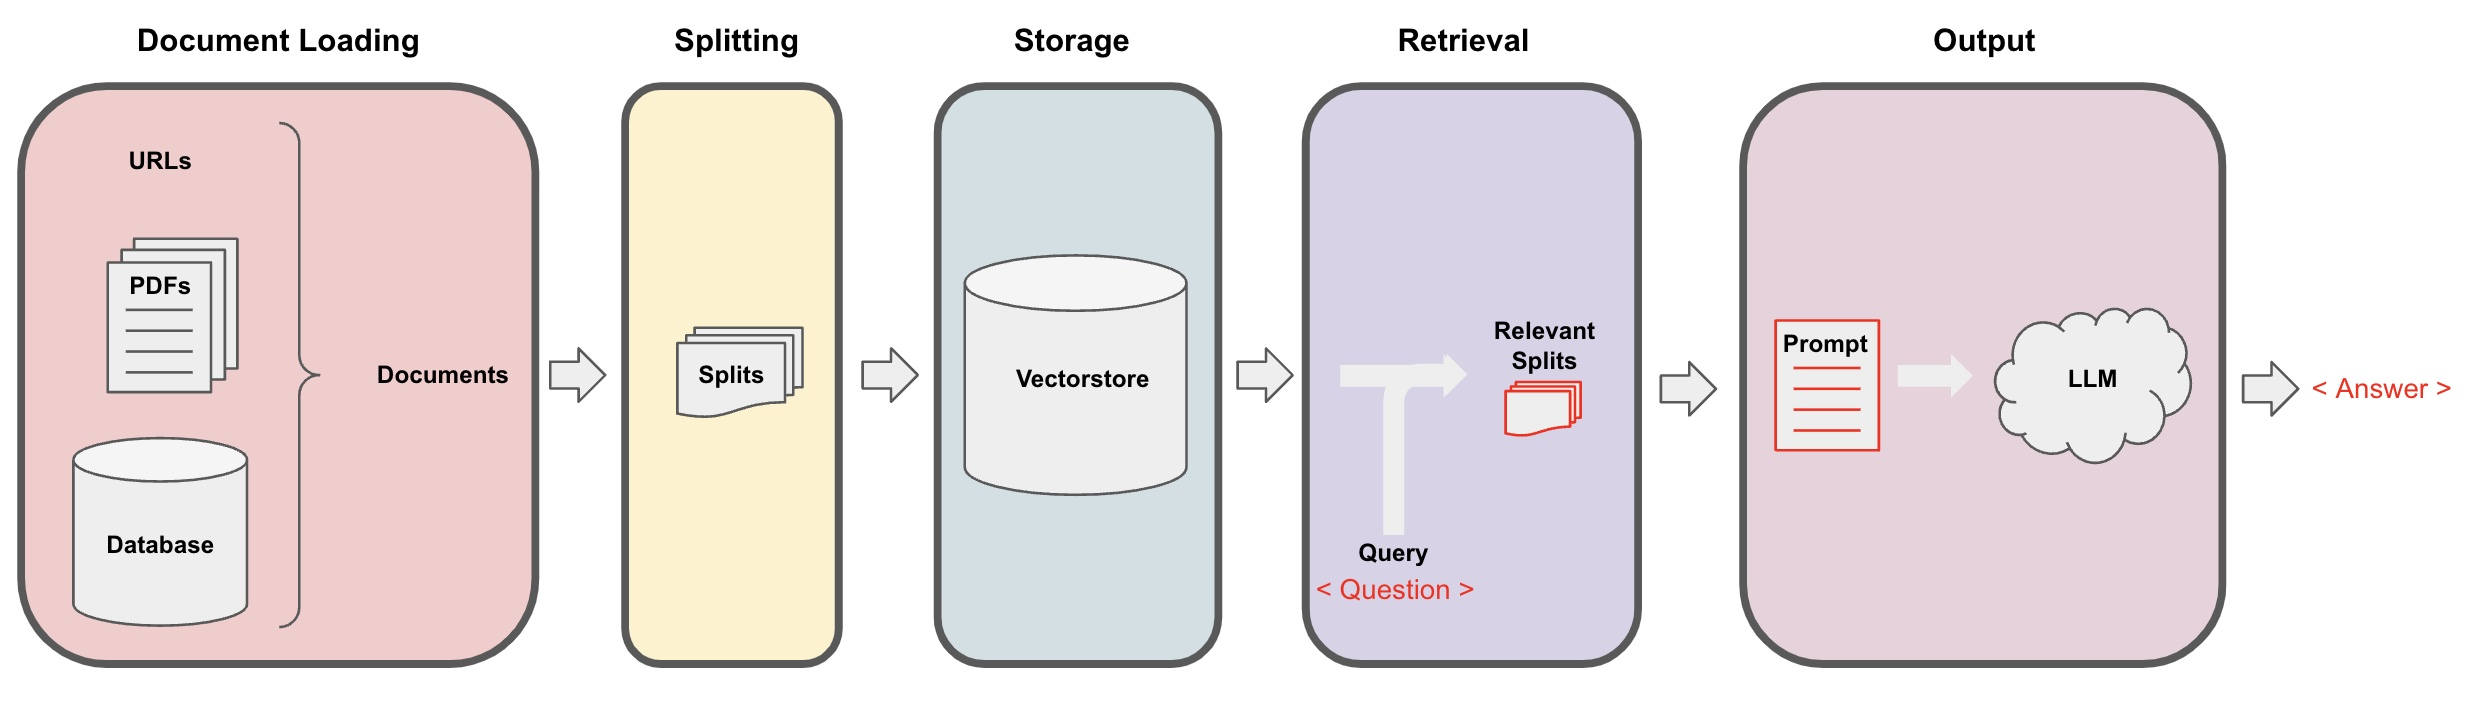

This includes `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

The `Retrieval` is used for output generation in Q+A using `RetrievalQA` chain.

The memory and retriever models can be alternated by changing the configuration in `load_db` function and the `convchain` method.

In [2]:
# Function to load and process JSON data
def load_db(file, chain_type, k):
    # Load JSON data
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    # Convert JSON data to string for processing
    documents = []
    for plant in json_data["plants"]:
        plant_name = plant["name"]
        for disease in plant["diseases"]:
            text = (
                f"Plant: {plant_name}\n"
                f"Disease Name: {disease['disease_name']}\n"
                f"Botanical Name: {disease['botanical_name']}\n"
                f"Symptoms: {disease['symptoms']}\n"
                f"Cause: {disease['cause']}\n"
                f"Comments: {disease['comments']}\n"
                f"Management: {disease['management']}\n"
            )
            documents.append(text)

    # Split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.create_documents(documents)

    # Define embedding
    embeddings = OpenAIEmbeddings()

    # Create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)

    # Define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})

    # Create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0),
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa

In [3]:
class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query = param.String("")
    db_response = param.List([])

    def __init__(self, **params):
        super(cbfs, self).__init__(**params)
        self.panels = []
        self.loaded_file = "knowledge_base.json"  # Default JSON file
        self.qa = load_db(self.loaded_file, "stuff", 4)

    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.json")  # Save local copy of JSON file
            self.loaded_file = file_input.filename
            button_load.button_style = "outline"
            self.qa = load_db("temp.json", "stuff", 4)
            button_load.button_style = "solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']

        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('Response:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  # Clears loading indicator when cleared
        return pn.WidgetBox(*self.panels, scroll=True)

    @param.depends('db_query')
    def get_lquest(self):
        if not self.db_query:
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("No DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query)
        )

    @param.depends('db_response')
    def get_sources(self):
        if not self.db_response:
            return
        rlist = [pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist = [pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self, count=0):
        self.chat_history = []
        return

# GUI

The expert system interface where user interaction.

[Panel](https://panel.holoviz.org/) and [Param](https://param.holoviz.org/) have many useful features and widgets you can use to extend the GUI.

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter your query here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=400, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.json')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
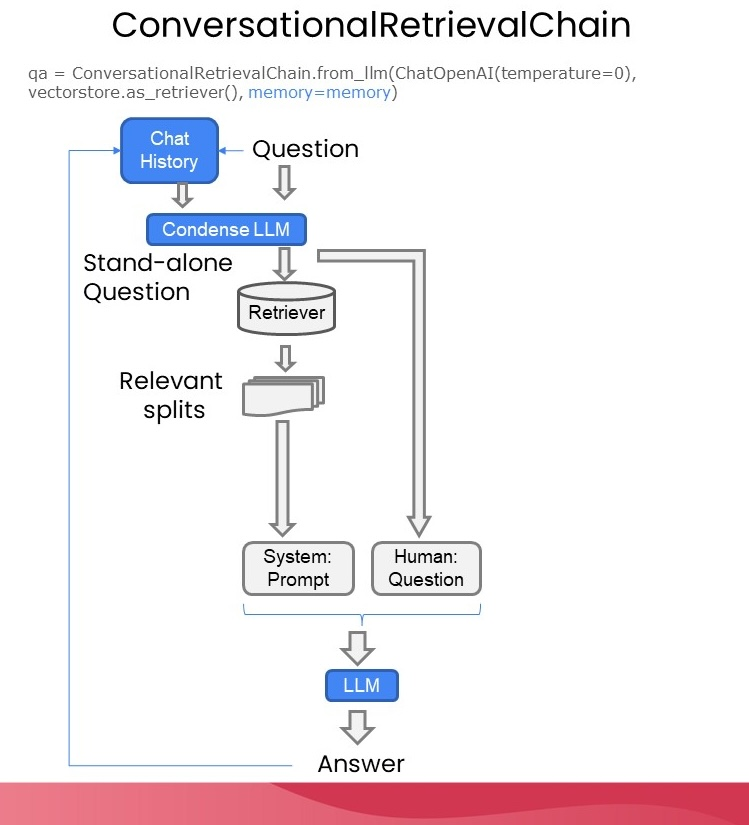

In [5]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.json')  # Accept only JSON files
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput(placeholder='Enter your query here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp)

jpg_pane = pn.pane.Image('convolangchain.jpeg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation, loading_indicator=True, height=400),
    pn.layout.Divider(),
)
tab2 = pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources),
)
tab3 = pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4 = pn.Column(
    pn.Row(file_input, button_load, bound_button_load),
    pn.Row(button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic")),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# Crop Disease Diagnosis and Management System')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3), ('Configure', tab4))
)
dashboard

# Unit Testing

In [8]:
class CustomTestResult(unittest.TestResult):
    def startTest(self, test):
        self._start_time = time.time()
        super().startTest(test)

    def addSuccess(self, test):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: OK (Time: {elapsed:.4f}s)")
        super().addSuccess(test)

    def addFailure(self, test, err):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: FAIL (Time: {elapsed:.4f}s)")
        super().addFailure(test, err)

    def addError(self, test, err):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: ERROR (Time: {elapsed:.4f}s)")
        super().addError(test, err)

class TestExpertSystem(unittest.TestCase):

    def setUp(self):
        # Initialize the expert system object
        self.cb = cbfs()

    def test_symptom_matching(self):
        # Test the system's ability to match symptoms
        self.cb.call_load_db(0)
        query = "What disease causes yellow leaves in beans?"
        response_panel = self.cb.convchain(query)
        self.assertIn('yellow', self.cb.db_query.lower(), "The generated DB query should relate to yellow leaves")
        self.assertGreater(len(self.cb.db_response), 0, "Should return at least one source document")
        self.assertIn('leaves', self.cb.answer.lower(), "The response should mention leaves")

    def test_database_query_generation(self):
        # Test the system's query generation
        query = "Why are the mango leaves turning brown?"
        self.cb.convchain(query)
        self.assertIn('mango', self.cb.db_query.lower(), "The generated DB query should include mango")
        self.assertIn('brown', self.cb.db_query.lower(), "The generated DB query should include brown")

    def test_response_generation(self):
        # Test the generation of a response based on a query
        query = "Why do onions have black spots?"
        response_panel = self.cb.convchain(query)
        self.assertIn('black spots', self.cb.answer.lower(), "The response should mention black spots")
        self.assertGreater(len(self.cb.answer), 0, "Generated response should not be empty")

    def test_clear_history(self):
        # Test the clearing of chat history
        query = "What is the disease affecting beans?"
        self.cb.convchain(query)
        self.assertGreater(len(self.cb.chat_history), 0, "Chat history should contain at least one entry")
        self.cb.clr_history()
        self.assertEqual(len(self.cb.chat_history), 0, "Chat history should be cleared")

# Create a custom test runner to use the custom result class
class CustomTestRunner(unittest.TextTestRunner):
    def _makeResult(self):
        return CustomTestResult()


In [9]:
# Running the tests in Jupyter notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestExpertSystem)
runner = CustomTestRunner(verbosity=2)
runner.run(suite)

test_clear_history: OK (Time: 5.4761s)
test_database_query_generation: OK (Time: 6.0052s)
test_response_generation: OK (Time: 5.9556s)
test_symptom_matching: OK (Time: 5.4538s)


Ran 4 tests in 22.893s

OK


<__main__.CustomTestResult run=4 errors=0 failures=0>